In [1]:
# Data Collection
import os

# Data Manipulation
import pandas as pd
import numpy as np

# Modeling
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Functionality
from medicalbiasdetection import utils

import warnings
warnings.filterwarnings("ignore")

# Notebook Settings
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)

# setup configuration files
config = utils.read_yaml()

# Global Variables
RUN = 3
RANDOM_STATE = 0
LOG_DIR = config['LOG']['dir'].format(RUN=RUN)
LOG_PATH = config['LOG']['path'].format(RUN=RUN)
os.environ['LOG_PATH'] = LOG_PATH
os.environ['RUN'] = str(RUN)


from medicalbiasdetection import model as md
from medicalbiasdetection import visualize as viz
from medicalbiasdetection import cohort
from medicalbiasdetection import process
from medicalbiasdetection import biasdetection as bd

## Load Data
- Note: Positive cases have been identified in the test set. Positive cases refer to those having at least one observed true sepsis hour


In [2]:
# Create four distinct datasets for evaluation
# 1) All features    
# 2) Protected features
# 3) All features positive cases   
# 4) Protected features positive cases
    
# dictionary to store the dataframes for each version of the dataset
results_dict = {"all_feat":None,"protected_feat":None,"all_feat_positive":None,"protected_feat_positive":None}

# create parameters to use to alter each dataset in the loop
ingest_params = { # data_type: [all or protected_feat features, all cases or sepsis only cases]
                 "all_feat":["all",False],
                 "protected_feat":["protected",False],
                 "all_feat_positive":["all",True],
                 "protected_feat_positive":["protected",True]
                    }

data_types_labels = {"all_feat":"All Features",
                     "protected_feat":"Protected Features",
                     "all_feat_positive":"All Features (Positive Cases)",
                     "protected_feat_positive":"Protected Features (Positive Cases)"
                    } 

# get csns with one positive sepsis hour
path = config['DIR']['cases'].format(RUN=RUN)
cases = pd.read_csv(path, index_col=0)['csn'].unique().tolist()

for data_type in results_dict:
    # print current run to console
    print(f"Running {data_types_labels[data_type]} dataset")
    
    # set flag for protected features data
    protected = ingest_params[data_type][0]
    
    # set flag for positivie cases
    positive = ingest_params[data_type][1]
    
    # get comorbidity information
    elix = config['meta']['elixhauser']
    
    # identify the list of columns to remove from the analysis
    drop_cols = config['biasdetection']['drop_cols'] + elix 
    
    if protected == "protected":
        drop_cols += config['biasdetection']['drop_static']
    
    # identify dummy columns
    dummy_cols = ['gender','race','insurance_status','community_type','n_CMBI'] #,'LANGUAGE'

    # load reference data and update patient cohort
    med_fac = 'grady' # 'grady' # 'emory'
    info_df = cohort.load_reference_data(med_fac, config)
    info_df = cohort.update_cohort(info_df)
    
    # ingest static patient feature data
    path = utils.create_filepath(config,'data','processed_data_patient_features.csv',RUN=RUN,TYPE='static')
    features_df = pd.read_csv(path, index_col=[0])

    # merge static features
    pat_df = info_df.merge(features_df, on='csn', copy=False)

    # list of the metrics used to develop the different models
    metric_list = ['Accuracy','F1_Score','F2_Score']

    # init dictionary to collect data
    metrics_dict = {}

    # set the file type for analysis
    file_type = 'test'
    
    for metric in metric_list:
        # create path to collect metrics
        path = utils.create_filepath(config,'predictions',f'prediction_results_{file_type}_summary.csv',RUN=RUN, OBJECTIVE=metric, TYPE='summary')
        
        # read data into temporary file
        tmp = pd.read_csv(path)
        
        # remove patients with no true positive hours in data
        if positive:
            tmp = tmp[tmp['csn'].isin(cases)]
               
        # merge the metric and static files and store in dictionary
        df = tmp.merge(pat_df, on='csn', copy=False)
        
        # create discretized bins for the comorbidity data
        bins =[0,2,5,8,np.inf]
        labels = ['CMBI: 0-2','CMBI: 3-5','CMBI: 6-8','CMBI: 9+']
        df['n_CMBI'] = pd.cut(df[elix].sum(axis=1),labels=labels,bins=bins,include_lowest=True)
        
        # clean patient data
        df_clean = cohort.oh_encode_pat_data(df, dummy_cols).drop(columns=drop_cols, errors='ignore')
        
        # store cleaned data
        metrics_dict[metric] = df_clean
        
        # print summary of prepared dataset
        print("METRIC REPORT")
        print(f"\t {metric} DataFrame")
        print(f"\t \t Rows: {metrics_dict[metric].shape[0]}")
        print(f"\t \t Columns: {metrics_dict[metric].shape[1]}")
        print("#"*30)
        
    # store metrics dictionary to results dictionary
    results_dict[data_type] = metrics_dict    
    print("#"*50)
    


Running All Features dataset
METRIC REPORT
	 Accuracy DataFrame
	 	 Rows: 5853
	 	 Columns: 153
##############################
METRIC REPORT
	 F1_Score DataFrame
	 	 Rows: 5853
	 	 Columns: 153
##############################
METRIC REPORT
	 F2_Score DataFrame
	 	 Rows: 5853
	 	 Columns: 153
##############################
##################################################
Running Protected Features dataset
METRIC REPORT
	 Accuracy DataFrame
	 	 Rows: 5853
	 	 Columns: 36
##############################
METRIC REPORT
	 F1_Score DataFrame
	 	 Rows: 5853
	 	 Columns: 36
##############################
METRIC REPORT
	 F2_Score DataFrame
	 	 Rows: 5853
	 	 Columns: 36
##############################
##################################################
Running All Features (Positive Cases) dataset
METRIC REPORT
	 Accuracy DataFrame
	 	 Rows: 2388
	 	 Columns: 153
##############################
METRIC REPORT
	 F1_Score DataFrame
	 	 Rows: 2388
	 	 Columns: 153
##############################
METRIC 

## Decision Trees for Threshold Analysis

Running All Features data
	 Running F1_Score


{'ccp_alpha': 0.0005,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 30,
 'min_samples_split': 30,
 'splitter': 'best'}

Model Score: 0.9986273164035689
Accuracy: 0.9986273164035689


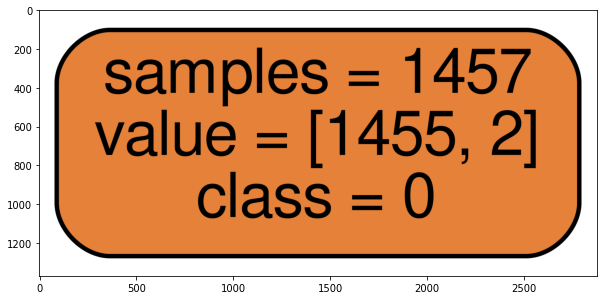

	 Running F2_Score


{'ccp_alpha': 0.0005,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 30,
 'min_samples_split': 30,
 'splitter': 'best'}

Model Score: 0.9993127147766323
Accuracy: 0.9993127147766323


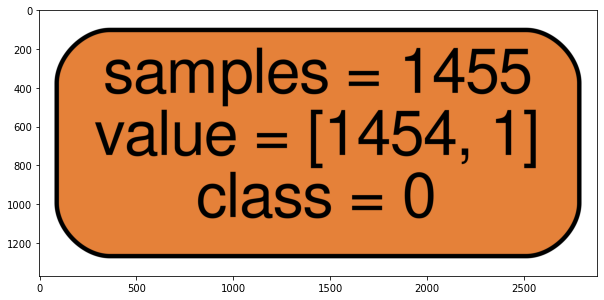

Running Protected Features data
	 Running F1_Score


{'ccp_alpha': 0.0005,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 30,
 'min_samples_split': 30,
 'splitter': 'best'}

Model Score: 0.9984544049459042
Accuracy: 0.9984544049459042


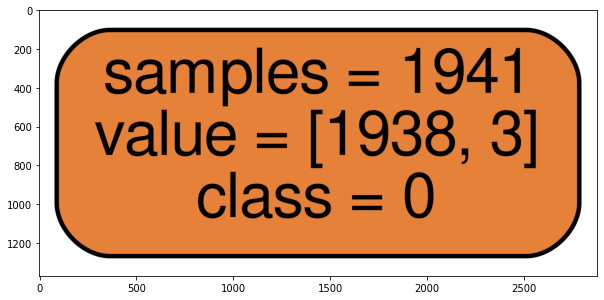

	 Running F2_Score


{'ccp_alpha': 0.0005,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 30,
 'min_samples_split': 30,
 'splitter': 'best'}

Model Score: 0.9989669421487604
Accuracy: 0.9989669421487604


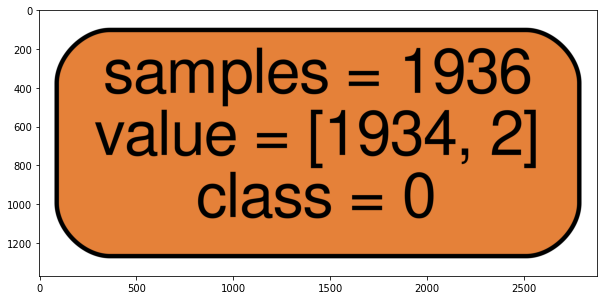

Running All Features (Positive Cases) data
	 Running F1_Score


{'ccp_alpha': 0.0005,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 30,
 'min_samples_split': 30,
 'splitter': 'best'}

Model Score: 0.9986273164035689
Accuracy: 0.9986273164035689


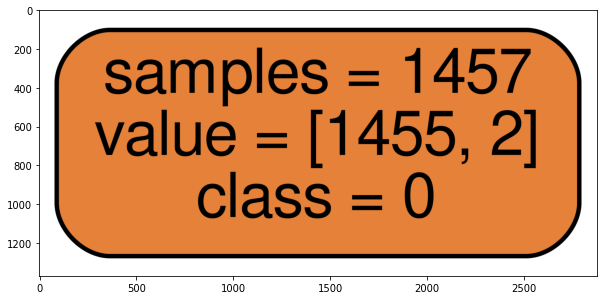

	 Running F2_Score


{'ccp_alpha': 0.0005,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 30,
 'min_samples_split': 30,
 'splitter': 'best'}

Model Score: 0.9993127147766323
Accuracy: 0.9993127147766323


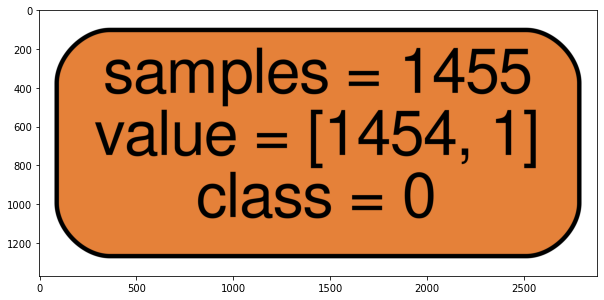

Running Protected Features (Positive Cases) data
	 Running F1_Score


{'ccp_alpha': 0.0005,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 30,
 'min_samples_split': 30,
 'splitter': 'best'}

Model Score: 0.9984544049459042
Accuracy: 0.9984544049459042


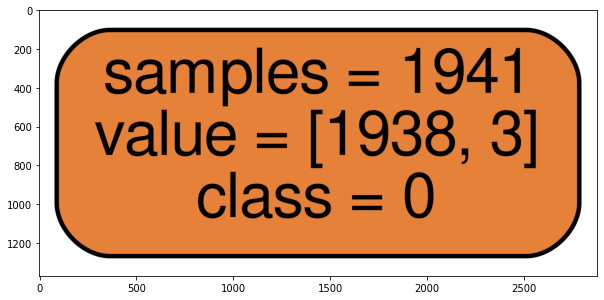

	 Running F2_Score


{'ccp_alpha': 0.0005,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 30,
 'min_samples_split': 30,
 'splitter': 'best'}

Model Score: 0.9989669421487604
Accuracy: 0.9989669421487604


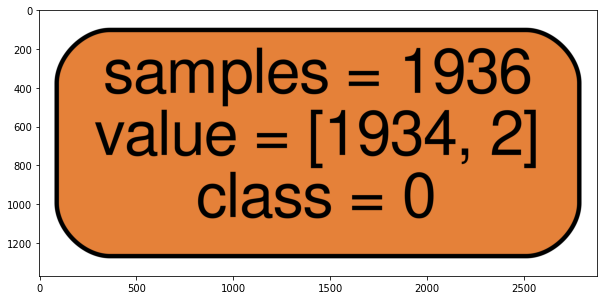

Running All Features data
	 Running F1_Score
	 Running F2_Score
Running Protected Features data
	 Running F1_Score
	 Running F2_Score
Running All Features (Positive Cases) data
	 Running F1_Score
	 Running F2_Score
Running Protected Features (Positive Cases) data
	 Running F1_Score
	 Running F2_Score
Running All Features data
	 Running F1_Score


{'ccp_alpha': 0.0005,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 30,
 'min_samples_split': 30,
 'splitter': 'best'}

Model Score: 0.9986273164035689
Accuracy: 0.9986273164035689


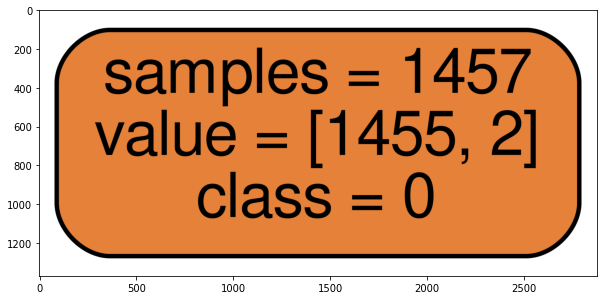

	 Running F2_Score


{'ccp_alpha': 0.0005,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 30,
 'min_samples_split': 30,
 'splitter': 'best'}

Model Score: 0.9993127147766323
Accuracy: 0.9993127147766323


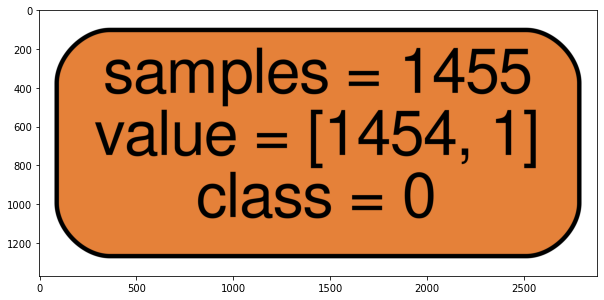

Running Protected Features data
	 Running F1_Score


{'ccp_alpha': 0.0005,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 30,
 'min_samples_split': 30,
 'splitter': 'best'}

Model Score: 0.9984544049459042
Accuracy: 0.9984544049459042


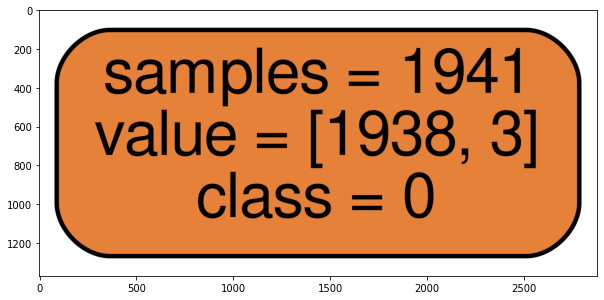

	 Running F2_Score


{'ccp_alpha': 0.0005,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 30,
 'min_samples_split': 30,
 'splitter': 'best'}

Model Score: 0.9989669421487604
Accuracy: 0.9989669421487604


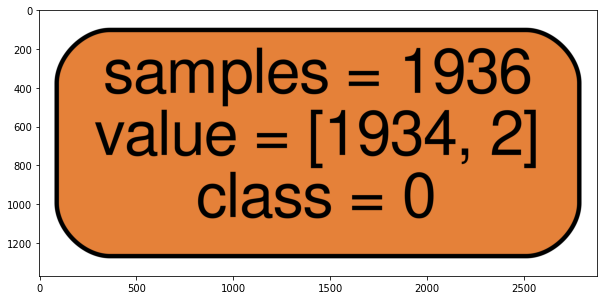

Running All Features (Positive Cases) data
	 Running F1_Score


{'ccp_alpha': 0.0005,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 30,
 'min_samples_split': 30,
 'splitter': 'best'}

Model Score: 0.9986273164035689
Accuracy: 0.9986273164035689


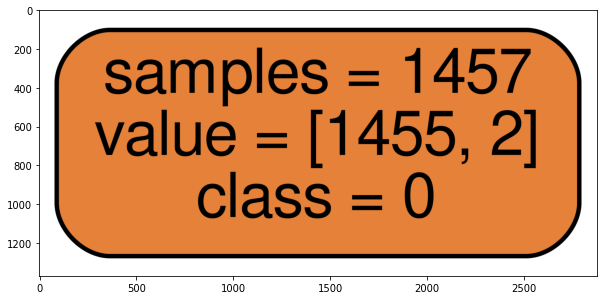

	 Running F2_Score


{'ccp_alpha': 0.0005,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 30,
 'min_samples_split': 30,
 'splitter': 'best'}

Model Score: 0.9993127147766323
Accuracy: 0.9993127147766323


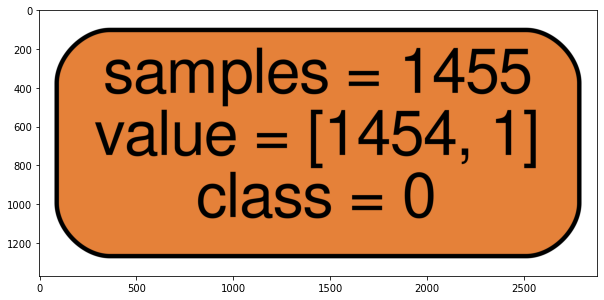

Running Protected Features (Positive Cases) data
	 Running F1_Score


{'ccp_alpha': 0.0005,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 30,
 'min_samples_split': 30,
 'splitter': 'best'}

Model Score: 0.9984544049459042
Accuracy: 0.9984544049459042


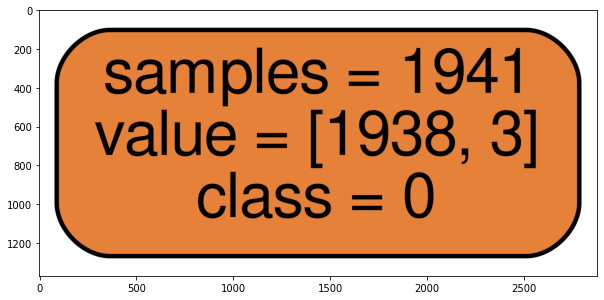

	 Running F2_Score


{'ccp_alpha': 0.0005,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 30,
 'min_samples_split': 30,
 'splitter': 'best'}

Model Score: 0.9989669421487604
Accuracy: 0.9989669421487604


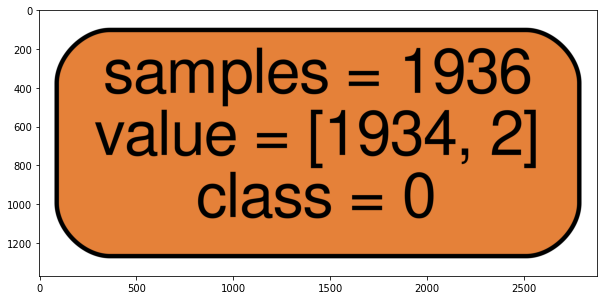

Running All Features data
	 Running F1_Score
	 Running F2_Score
Running Protected Features data
	 Running F1_Score
	 Running F2_Score
Running All Features (Positive Cases) data
	 Running F1_Score
	 Running F2_Score
Running Protected Features (Positive Cases) data
	 Running F1_Score
	 Running F2_Score
Running All Features data
	 Running F1_Score


{'ccp_alpha': 0.0005,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 30,
 'min_samples_split': 30,
 'splitter': 'best'}

Model Score: 0.9986273164035689
Accuracy: 0.9986273164035689


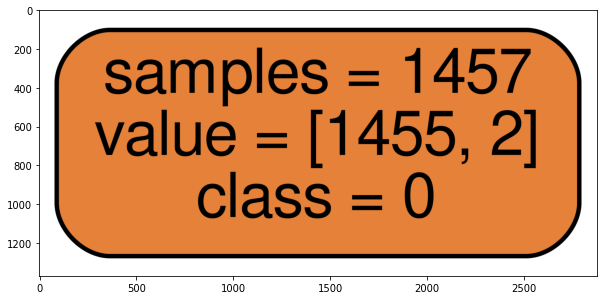

	 Running F2_Score


{'ccp_alpha': 0.0005,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 30,
 'min_samples_split': 30,
 'splitter': 'best'}

Model Score: 0.9993127147766323
Accuracy: 0.9993127147766323


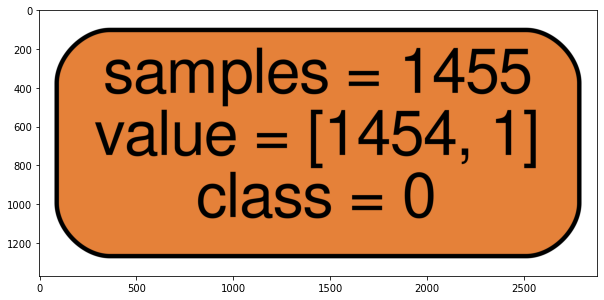

Running Protected Features data
	 Running F1_Score


{'ccp_alpha': 0.0005,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 30,
 'min_samples_split': 30,
 'splitter': 'best'}

Model Score: 0.9984544049459042
Accuracy: 0.9984544049459042


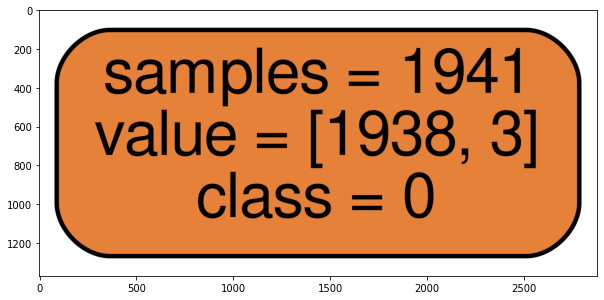

	 Running F2_Score


{'ccp_alpha': 0.0005,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 30,
 'min_samples_split': 30,
 'splitter': 'best'}

Model Score: 0.9989669421487604
Accuracy: 0.9989669421487604


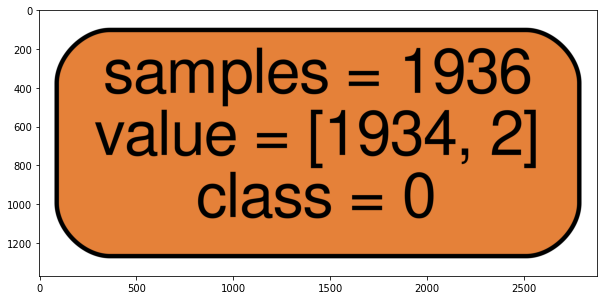

Running All Features (Positive Cases) data
	 Running F1_Score


{'ccp_alpha': 0.0005,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 30,
 'min_samples_split': 30,
 'splitter': 'best'}

Model Score: 0.9986273164035689
Accuracy: 0.9986273164035689


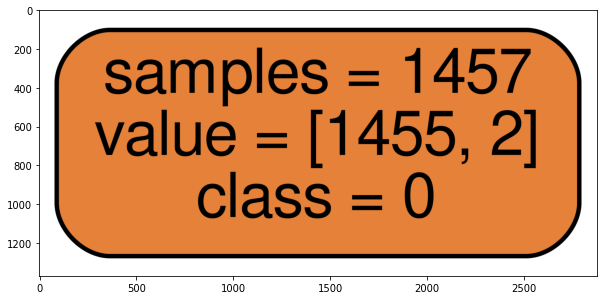

	 Running F2_Score


{'ccp_alpha': 0.0005,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 30,
 'min_samples_split': 30,
 'splitter': 'best'}

Model Score: 0.9993127147766323
Accuracy: 0.9993127147766323


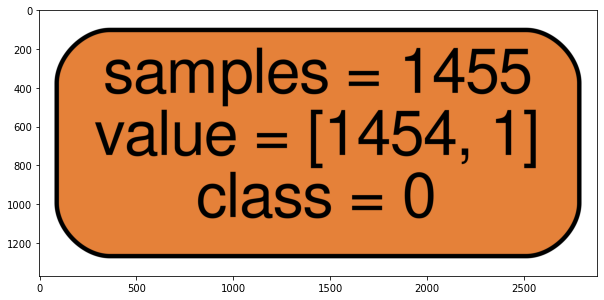

Running Protected Features (Positive Cases) data
	 Running F1_Score


{'ccp_alpha': 0.0005,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 30,
 'min_samples_split': 30,
 'splitter': 'best'}

Model Score: 0.9984544049459042
Accuracy: 0.9984544049459042


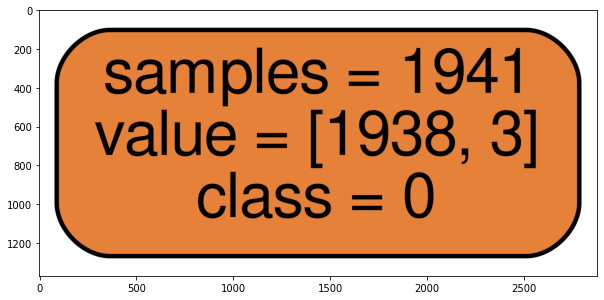

	 Running F2_Score


{'ccp_alpha': 0.0005,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 30,
 'min_samples_split': 30,
 'splitter': 'best'}

Model Score: 0.9989669421487604
Accuracy: 0.9989669421487604


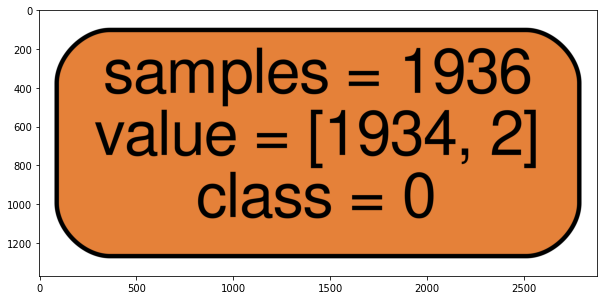

Running All Features data
	 Running F1_Score
	 Running F2_Score
Running Protected Features data
	 Running F1_Score
	 Running F2_Score
Running All Features (Positive Cases) data
	 Running F1_Score
	 Running F2_Score
Running Protected Features (Positive Cases) data
	 Running F1_Score
	 Running F2_Score
Running All Features data
	 Running F1_Score


{'ccp_alpha': 0.0005,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 30,
 'min_samples_split': 30,
 'splitter': 'best'}

Model Score: 0.9986273164035689
Accuracy: 0.9986273164035689


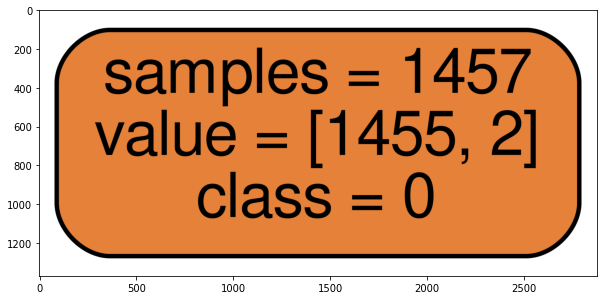

	 Running F2_Score


{'ccp_alpha': 0.0005,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 30,
 'min_samples_split': 30,
 'splitter': 'best'}

Model Score: 0.9993127147766323
Accuracy: 0.9993127147766323


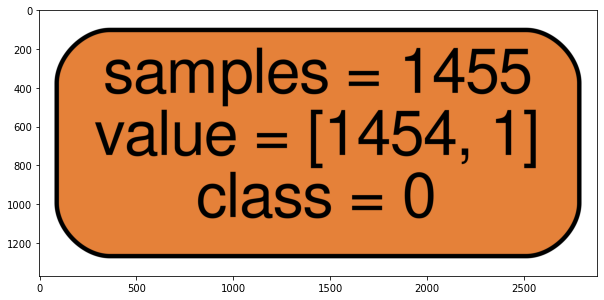

Running Protected Features data
	 Running F1_Score


{'ccp_alpha': 0.0005,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 30,
 'min_samples_split': 30,
 'splitter': 'best'}

Model Score: 0.9984544049459042
Accuracy: 0.9984544049459042


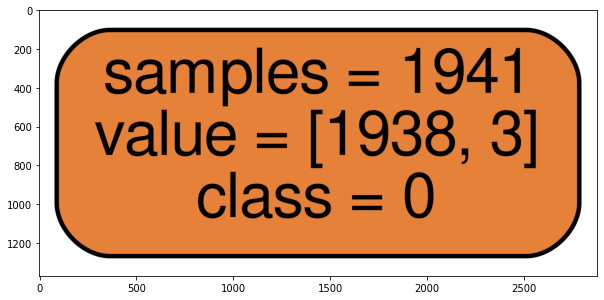

	 Running F2_Score


{'ccp_alpha': 0.0005,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 30,
 'min_samples_split': 30,
 'splitter': 'best'}

Model Score: 0.9989669421487604
Accuracy: 0.9989669421487604


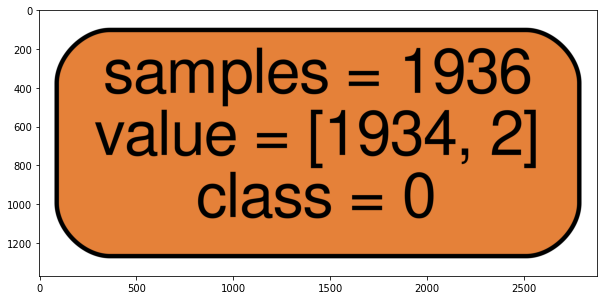

Running All Features (Positive Cases) data
	 Running F1_Score


{'ccp_alpha': 0.0005,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 30,
 'min_samples_split': 30,
 'splitter': 'best'}

Model Score: 0.9986273164035689
Accuracy: 0.9986273164035689


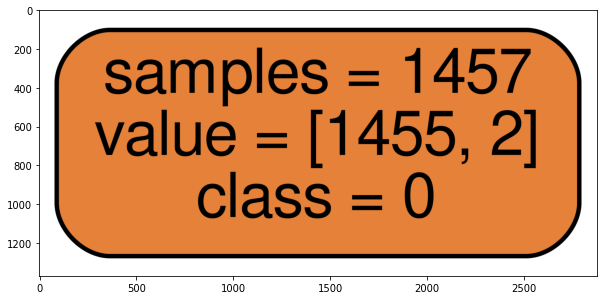

	 Running F2_Score


{'ccp_alpha': 0.0005,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 30,
 'min_samples_split': 30,
 'splitter': 'best'}

Model Score: 0.9993127147766323
Accuracy: 0.9993127147766323


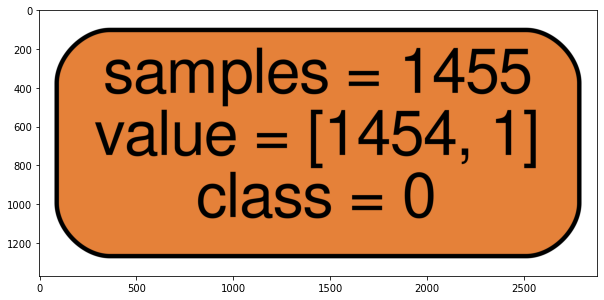

Running Protected Features (Positive Cases) data
	 Running F1_Score


{'ccp_alpha': 0.0005,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 30,
 'min_samples_split': 30,
 'splitter': 'best'}

Model Score: 0.9984544049459042
Accuracy: 0.9984544049459042


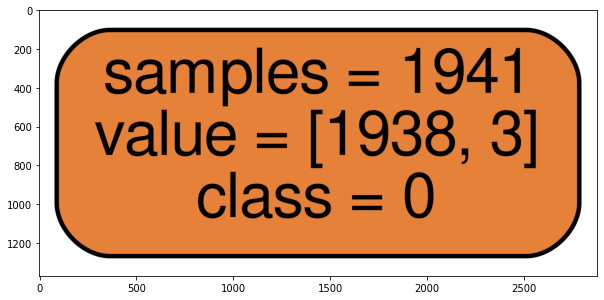

	 Running F2_Score


{'ccp_alpha': 0.0005,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 30,
 'min_samples_split': 30,
 'splitter': 'best'}

Model Score: 0.9989669421487604
Accuracy: 0.9989669421487604


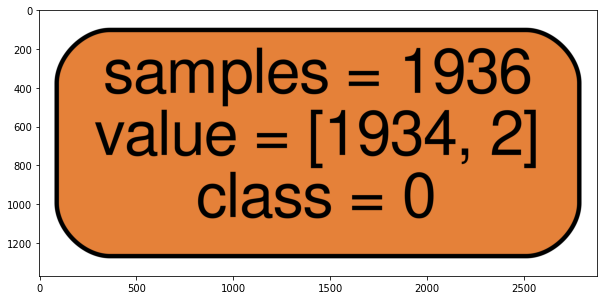

Running All Features data
	 Running F1_Score
	 Running F2_Score
Running Protected Features data
	 Running F1_Score
	 Running F2_Score
Running All Features (Positive Cases) data
	 Running F1_Score
	 Running F2_Score
Running Protected Features (Positive Cases) data
	 Running F1_Score
	 Running F2_Score
Running All Features data
	 Running F1_Score


{'ccp_alpha': 0.0005,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 30,
 'min_samples_split': 30,
 'splitter': 'best'}

Model Score: 0.9986273164035689
Accuracy: 0.9986273164035689


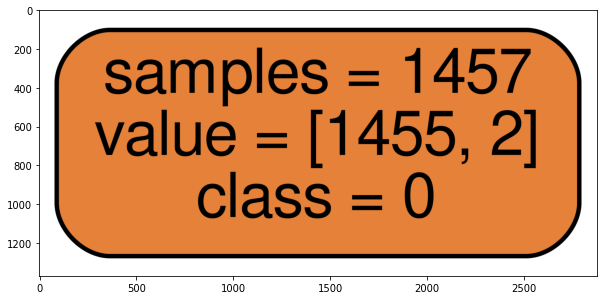

	 Running F2_Score


{'ccp_alpha': 0.0005,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 30,
 'min_samples_split': 30,
 'splitter': 'best'}

Model Score: 0.9993127147766323
Accuracy: 0.9993127147766323


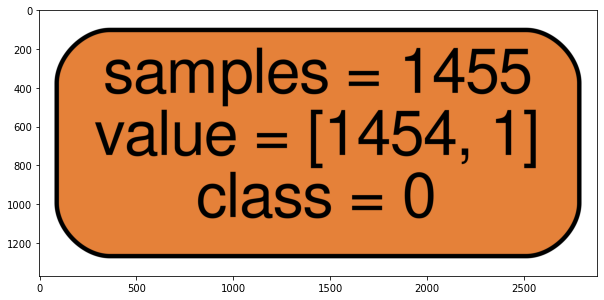

Running Protected Features data
	 Running F1_Score


{'ccp_alpha': 0.0005,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 30,
 'min_samples_split': 30,
 'splitter': 'best'}

Model Score: 0.9984544049459042
Accuracy: 0.9984544049459042


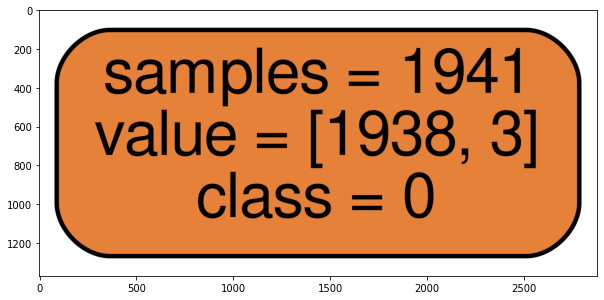

	 Running F2_Score


{'ccp_alpha': 0.0005,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 30,
 'min_samples_split': 30,
 'splitter': 'best'}

Model Score: 0.9989669421487604
Accuracy: 0.9989669421487604


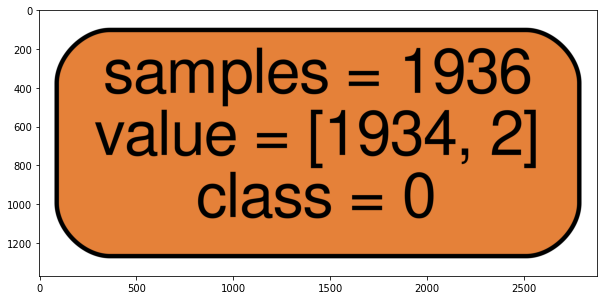

Running All Features (Positive Cases) data
	 Running F1_Score


{'ccp_alpha': 0.0005,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 30,
 'min_samples_split': 30,
 'splitter': 'best'}

Model Score: 0.9986273164035689
Accuracy: 0.9986273164035689


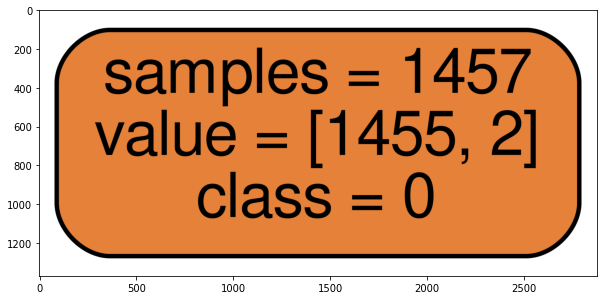

	 Running F2_Score


{'ccp_alpha': 0.0005,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 30,
 'min_samples_split': 30,
 'splitter': 'best'}

Model Score: 0.9993127147766323
Accuracy: 0.9993127147766323


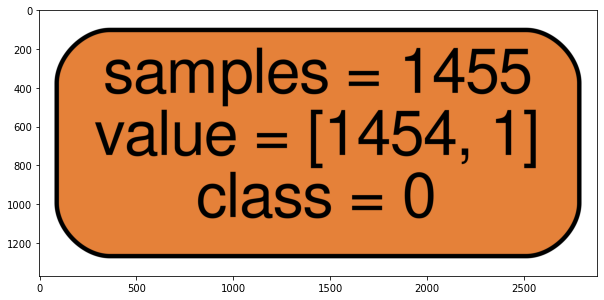

Running Protected Features (Positive Cases) data
	 Running F1_Score


{'ccp_alpha': 0.0005,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 30,
 'min_samples_split': 30,
 'splitter': 'best'}

Model Score: 0.9984544049459042
Accuracy: 0.9984544049459042


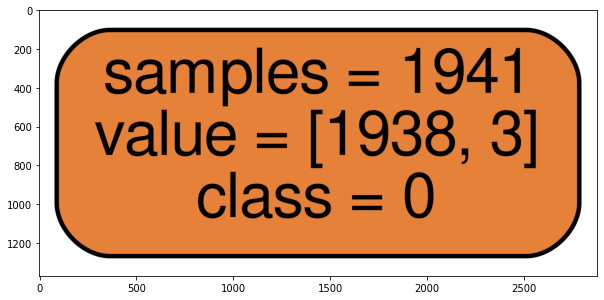

	 Running F2_Score


{'ccp_alpha': 0.0005,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 30,
 'min_samples_split': 30,
 'splitter': 'best'}

Model Score: 0.9989669421487604
Accuracy: 0.9989669421487604


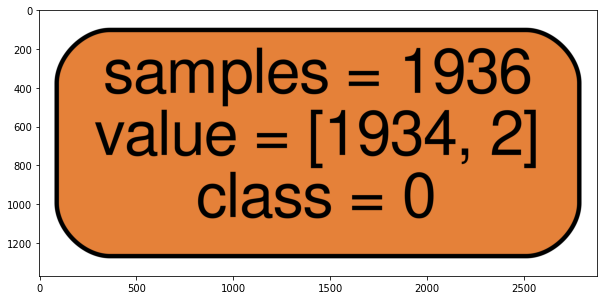

Running All Features data
	 Running F1_Score
	 Running F2_Score
Running Protected Features data
	 Running F1_Score
	 Running F2_Score
Running All Features (Positive Cases) data
	 Running F1_Score
	 Running F2_Score
Running Protected Features (Positive Cases) data
	 Running F1_Score
	 Running F2_Score


In [6]:
verbose = True

# list of data types for processing
data_types_list = ["all_feat","protected_feat","all_feat_positive","protected_feat_positive"] # "all_feat","protected_feat","all_feat_positive","protected_feat_positive"

# list the analysis type
analysis_list = ["Original","Specificity"] #,"Specificity","Original"

# create a list of the metrics used to develop the different models
metric_list = ['F1_Score','F2_Score'] #'Accuracy','F1_Score','F2_Score'

# dict to map col names
metric_map = {'Accuracy':'accuracy','F1_Score':'f1_score','F2_Score':'f2_score'}

# get the subdirectory of threshold values
path = f"MBD_Runs/{RUN}/thresholds"
values = np.sort([x for x in os.listdir(path)if '0' in x])

# for each threshold value
for thresh_val in values:
    
    # for each analysis type
    for analysis in analysis_list:

        # for each data type of interest
        for data_type in data_types_list:
            # log current data type that is running to the console
            print(f"Running {data_types_labels[data_type]} data")

            # for each metric
            for metric in metric_list:
                print(f"\t Running {metric}")

                # create design matrix
                X = results_dict[data_type][metric].copy()

                # start removed csn report text
                removed_text = f"\nStarting CSNs: {X.shape[0]}\nRemoved CSNs:\n"

                # Remove instances where F2 score is zero when using the F2-score as the metric
                if metric == 'F2_Score':

                    rows = X[X['true_positive']>0.0].index
                    # update removed csn report
                    X, removed_text = bd.report_removed_records(X,removed_text,rows,"True Positive values = 0")

                # Remove instances where F2 score is zero when using the F2-score as the metric
                if metric == 'F1_Score':

                    rows = X[X['true_positive']>0.0].index
                    # update removed csn report
                    X, removed_text = bd.report_removed_records(X,removed_text,rows,"True Positive values = 0")

                # Update the response variable based on the type of analysis
                if analysis == "Original":

                    # remove missing rows excluding those in the fpr column
                    rows = X.drop(columns=['fpr']).dropna(axis=0).index
                    X, removed_text = bd.report_removed_records(X,removed_text,rows,"Patients have missing values")

                    # remove rows with infinite values
                    rows = X[np.isinf(X).sum(axis=1)==0].index
                    X, removed_text = bd.report_removed_records(X,removed_text,rows,"Patients have infinite values")

                    # apply thresholding to data
                    X, threshold = bd.apply_metric_threshold(X, metric=metric_map[metric], n_std = float(thresh_val))

                    # create response vector
                    y = X['target']

                    # create dataframe of performance metrics
                    performance_cols = ['csn','accuracy','f1_score','f2_score']
                    performance_df = X[performance_cols]

                    # drop remaining metrics from design matrix
                    X.drop(columns=['csn','accuracy','f1_score','f2_score','target','roc_auc','mcc','fpr','PAT_ENC_CSN_ID', 'max_SOFA',
                                    'gcs_total_score_mean','gcs_total_score_min','gcs_total_score_max',
                                    'gcs_total_score_std','gcs_total_score_median','procedure_min', 
                                    'procedure_max', 'procedure_mean','tpr','true_negative','false_positive',
                                    'false_negative','true_positive','recall','precision'],inplace=True, errors='ignore')

                elif analysis == "Specificity":


                    # drop rows with fpr equal to Nan
                    rows = X[~X['fpr'].isna()].index
                    X, removed_text = bd.report_removed_records(X,removed_text,rows,"Patients with False Positive Rate = NaN")

                    # remove missing rows excluding those in the fpr column
                    rows = X.dropna(axis=0).index
                    X, removed_text = bd.report_removed_records(X,removed_text,rows,"Patients have missing values")

                    # remove rows with infinite values
                    rows = X[np.isinf(X).sum(axis=1)==0].index
                    X, removed_text = bd.report_removed_records(X,removed_text,rows,"Patients have infinite values")

                    # create response vector
                    y = X['fpr']

                    # create specificity metric
                    y = 1-y

                    # update design matrix to include specificity
                    X['specificity'] = y

                    # apply thresholding to data
                    X, threshold = bd.apply_metric_threshold(X, metric='specificity', n_std = float(thresh_val))

                    # create response vector from threshold
                    y = X['target']

                    # create dataframe of performance metrics
                    performance_cols = ['csn','accuracy','f1_score','f2_score','fpr','specificity']
                    performance_df = X[performance_cols]

                    # drop remaining metrics from design matrix
                    X.drop(columns=['csn','accuracy','f1_score','f2_score','target','specificity','mcc','roc_auc','PAT_ENC_CSN_ID', 'max_SOFA',
                                    'gcs_total_score_mean','gcs_total_score_min','gcs_total_score_max',
                                    'gcs_total_score_std','gcs_total_score_median','procedure_min', 
                                    'procedure_max', 'procedure_mean','fpr','tpr','true_negative','false_positive',
                                    'false_negative','true_positive','recall','precision'],inplace=True, errors='ignore')


                # Create Naive Decision Tree Regression Model
                model = DecisionTreeClassifier(min_samples_leaf=30, random_state=RANDOM_STATE)    

                # grid of hyperparameters to search
                params = {
                    "criterion":["gini", "entropy"], #,"absolute_error"
                    "splitter":["best"],
                    "ccp_alpha": [0.0005, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5],
                    "max_depth" : [5,7,9,15],
                    "min_samples_leaf":[30,50,70,100],
                    "min_samples_split":[30,60,100,150,200,300],
                    "max_features":["auto","log2","sqrt"],
                    }

                # get threshold information
                n = performance_df.shape[0]
                n_lt = performance_df[performance_df[metric_map[metric]]<threshold].shape[0]
                n_gt = performance_df[performance_df[metric_map[metric]]>=threshold].shape[0]

                if analysis == 'Specificity':
                    n_lt = performance_df[performance_df['specificity']<threshold].shape[0]
                    n_gt = performance_df[performance_df['specificity']>=threshold].shape[0] 

                # Data shape check
                if X.shape[0]<=30:
                    path = config['DIR']['thresholds'].format(RUN=RUN, VALUE = thresh_val, OBJECTIVE=metric)
                    if analysis == 'Specificity':
                        filename = f"specificity_{data_type}_report.txt"
                        # create report text
                        report_text =f"Specificity Model unable to run due to having {X.shape[0]} records"
                    else:
                        filename = f"{data_type}_report.txt"
                        # create report text
                        report_text =f"{metric} Model unable to run due to having {X.shape[0]} records"

                    report_file_path = os.path.join(path,filename)
                    # save report text
                    with open(report_file_path, 'w') as file:
                        file.write(report_text)
                    continue


                # perform grid search to find best parameters for decision tree model
                clf = GridSearchCV(model,params,scoring='neg_mean_squared_error',cv=5)
                clf.fit(X,y)

                display(clf.best_params_)

                # create decision tree model with optimized hyperparameters
                model = DecisionTreeClassifier(random_state = RANDOM_STATE,**clf.best_params_)
                model = model.fit(X, y)
                y_pred = model.predict(X)

                model_score = model.score(X,y)
                acc_score = accuracy_score(y, y_pred)
                print(f"Model Score: {model_score}")
                print(f"Accuracy: {acc_score}")

                # update performance data inforamtion
                performance_df['node'] = model.apply(X)

                # Get feature names from data
                feature_names = X.columns

                # Set path to save figures
                path = config['DIR']['thresholds'].format(RUN=RUN, VALUE = thresh_val, OBJECTIVE=metric) 
                filename = f"decisionTree_threshold_{data_type}.png"
                if analysis == 'Specificity':
                    filename = f"decisionTree_threshold_specificity_{data_type}.png"
                img_path = os.path.join(path,filename)

                # create modeling report path
                filename = f"{data_type}_report.txt"
                if analysis == 'Specificity':
                    filename = f"specificity_{data_type}_report.txt"
                report_file_path = os.path.join(path,filename)

                # generate text for each metric
                metrics_text = f"\nModel Results:\n \tScore = {model_score:0.3f}\n\tAccuracy = {acc_score:0.3f}\n\nMetric Results({metric}):\n\tAverage = {performance_df[metric_map[metric]].mean():.3f}\n\tStandard Deviation = {performance_df[metric_map[metric]].std():.3f}\n"
                if analysis == 'Specificity':
                    metrics_text = f"\nModel Results:\n \tScore = {model_score:0.3f}\n\tAccuracy = {acc_score:0.3f}\n\nMetric Results(Specificity):\n\tAverage = {performance_df['specificity'].mean():.3f}\n\tStandard Deviation = {performance_df['specificity'].std():.3f}\n"
                # update removed_text
                removed_text += f"Total patients analyzed: {X.shape[0]}\n"

                # generate threshold text
                threshold_text = f"\nThreshold = {threshold:.3f}\nBelow Threshold = {n_lt} ({(np.round(n_lt/n,3)*100)}%)\nAbove Threshold = {n_gt} ({(np.round(n_gt/n,3)*100)}%)\n"
                # generate text for best parameters
                best_param_text = "\nBest Parameters:\n" + "\n".join([f"{k} = {v}"for k,v in clf.best_params_.items()])
                # create report text
                report_text = metrics_text + threshold_text + removed_text +  best_param_text
                # save report text
                with open(report_file_path, 'w') as file:
                    file.write(report_text)

                # Access the tree object
                tree = model.tree_

                # List for terminal nodes
                terminal_nodes = []
                positive_nodes = []
                negative_nodes = []

                # List for threshold dataframes
                threshold_df_arr = []

                # Iterate over all nodes and get labels for each terminal node
                for node in range(tree.node_count):
                    # Check if it's a terminal node
                    if tree.children_left[node] == tree.children_right[node] == -1:
                        # The predicted class for each leaf node
                        predicted_class = np.argmax(tree.value[node])
                        terminal_nodes.append([node,predicted_class])
                        if predicted_class == 0:
                            negative_nodes.append(node)
                        else:
                            positive_nodes.append(node)
                if analysis == 'Specificity':
                    bd.generate_threshold_tree_graph(model,feature_names,['0','1'],performance_df,'specificity',outpath=img_path, positive_nodes = positive_nodes,verbose=True, reverse=True)
                else:
                    bd.generate_threshold_tree_graph(model,feature_names,['0','1'],performance_df,metric_map[metric],outpath=img_path, positive_nodes = positive_nodes,verbose=True, reverse=True)

